In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
sample_a = pd.read_csv('sample_a.csv')
sample_b = pd.read_csv('sample_b.csv')
sample_c = pd.read_csv('sample_c.csv')
item_prices = pd.read_csv('item_prices.csv')

In [3]:
sample_a.shape

(1188912, 3)

In [4]:
sample_a

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0
...,...,...,...
1188907,22999,2401,1
1188908,23700,4654,0
1188909,18842,3707,1
1188910,32732,9198,1


In [5]:
sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


In [6]:
sample_b.shape

(1198438, 3)

In [7]:
sample_b

,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1
...,...,...,...
1198433,184760,2645,1
1198434,163544,1371,2
1198435,153724,3788,1
1198436,176308,4164,1


In [8]:
sample_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


In [9]:
sample_c.shape

(1205510, 3)

In [10]:
sample_c

,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2
...,...,...,...
1205505,286691,2188,1
1205506,218099,4143,1
1205507,227599,5391,0
1205508,278847,4853,1


In [11]:
sample_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


Пропусков в данных нет, все колонки во всех 3 датасетах одинаковые, количество строк различаются, но разница относительно небольшая

In [12]:
item_prices.shape

(1000, 2)

In [13]:
item_prices

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804
...,...,...
995,3463,1300
996,1573,716
997,610,1748
998,4452,386


In [14]:
item_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   item_id     1000 non-null   int64
 1   item_price  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


## Preprocessing

In [15]:
item_prices[item_prices.duplicated()].value_counts()

Series([], dtype: int64)

In [16]:
item_prices.shape

(1000, 2)

In [17]:
item_prices = item_prices.groupby(['item_id']).max()
item_prices['item_id'] = item_prices.index
item_prices = item_prices.reset_index(drop=True)
item_prices.shape

(955, 2)

In [18]:
item_prices

,item_price,item_id
0,452,21
1,282,36
2,1746,39
3,871,50
4,1479,64
...,...,...
950,379,9936
951,810,9944
952,265,9958
953,479,9989


In [19]:
sample_a[sample_a.duplicated()].value_counts()

Series([], dtype: int64)

In [20]:
sample_a['action_id'].value_counts()

1    951130
0    190226
2     47556
Name: action_id, dtype: int64

In [21]:
sample_b[sample_b.duplicated()].value_counts()

Series([], dtype: int64)

In [22]:
sample_b['action_id'].value_counts()

1    951141
0    152183
2     95114
Name: action_id, dtype: int64

In [23]:
sample_c[sample_c.duplicated()].value_counts()

Series([], dtype: int64)

In [24]:
sample_c['action_id'].value_counts()

1    949221
0    199336
2     56953
Name: action_id, dtype: int64

In [25]:
#Visualisation

sample_set = [sample_a, sample_b, sample_c]

actions_dict = {0: 'click',
                1: 'browse',
                2: 'purchase'}

for data in sample_set:
    data['action'] = data['action_id'].map(actions_dict)
    
#Sample A
actions = sample_a.action.value_counts().index.tolist()
counts = sample_a.action.value_counts().values.tolist()

df_sample_a = {'action': actions,
                'count': counts,
                'sample': 'Sample A'}

df_sample_a = pd.DataFrame(df_sample_a)

#Sample B
actions = sample_b.action.value_counts().index.tolist()
counts = sample_b.action.value_counts().values.tolist()

df_sample_b = {'action': actions,
                'count': counts,
                'sample': 'Sample B'}

df_sample_b = pd.DataFrame(df_sample_b)

#Sample C
actions = sample_c.action.value_counts().index.tolist()
counts = sample_c.action.value_counts().values.tolist()

df_sample_c = {'action': actions,
                'count': counts,
                'sample': 'Sample C'}

df_sample_c = pd.DataFrame(df_sample_c)

#Concatenation
df_full = pd.concat([df_sample_a, df_sample_b, df_sample_c]).reset_index(drop=True)

[Text(0.5, 1.0, 'User actions distribution')]

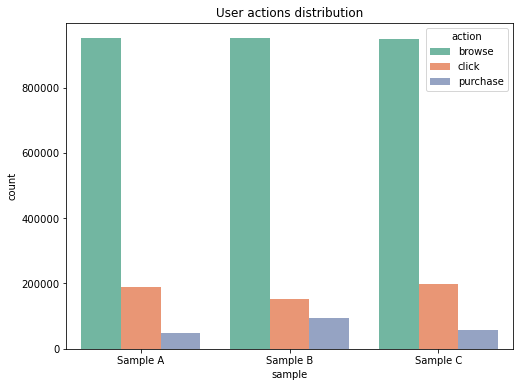

In [53]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="sample",
            y="count",
            hue="action",
            data=df_full,
            palette="Set2").set(title="User actions distribution")

Как можно заметить, количество просмотров во всех датасетах везде очень высоко и примерно одинакво. В группе B гораздо больше покупок, при меньшем количестве кликов.

Проверим правильность последовательности действий: просмотр-клик-покупка

In [27]:
def get_pivot(data):
    
    #Pivoting
    piv_t = pd.pivot_table(data,
                              values='action_id',
                              index=['user_id', 'item_id'],
                              columns=['action'])
    
    #Indexing
    cols = ['user_id', 'item_id', 'browse', 'click', 'purchase']
    piv_t['user_id'] = piv_t.index.get_level_values(0)
    piv_t['item_id'] = piv_t.index.get_level_values(1)
    piv_t = piv_t.reset_index(drop=True)
    piv_t = piv_t.reindex(columns=cols)
    
    return piv_t

#Sample A
sample_a_piv = get_pivot(sample_a)

#Sample B
sample_b_piv = get_pivot(sample_b)

#Sample C
sample_c_piv = get_pivot(sample_c)

In [28]:
sample_a_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951130 entries, 0 to 951129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   951130 non-null  int64  
 1   item_id   951130 non-null  int64  
 2   browse    951130 non-null  float64
 3   click     190226 non-null  float64
 4   purchase  47556 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 36.3 MB


In [29]:
sample_b_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951141 entries, 0 to 951140
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   951141 non-null  int64  
 1   item_id   951141 non-null  int64  
 2   browse    951141 non-null  float64
 3   click     152183 non-null  float64
 4   purchase  95114 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 36.3 MB


In [30]:
sample_c_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949221 entries, 0 to 949220
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   949221 non-null  int64  
 1   item_id   949221 non-null  int64  
 2   browse    949221 non-null  float64
 3   click     199336 non-null  float64
 4   purchase  56953 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 36.2 MB


Первое действие - это всегда просмотр, судя по отсутствию пропусков в данных колонках, нарушений на этом шаге нет.

In [31]:
sample_a_piv = sample_a_piv.merge(item_prices, how='left', on='item_id')
sample_b_piv = sample_b_piv.merge(item_prices, how='left', on='item_id')
sample_c_piv = sample_c_piv.merge(item_prices, how='left', on='item_id')

## Metrics

Согласно заданию, маркетплейс ориентируется на следующие метрики:

ctr (отношение кликов к просмотрам товаров);

purchase rate (отношение покупок к просмотрам товаров);

gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

Добавим ещё количество уникальных покупателей и среднюю цену в каждом сампле

In [32]:
def get_ctr(data):
    ctr = len(data[~data.click.isna()])/len(data)
    return ctr
def get_purchase_rate(data):
    rate = len(data[~data.purchase.isna()])/len(data)
    return rate
def get_gmv(data):
    gmv = data[~data.purchase.isna()]['item_price'].sum()
    return gmv

In [33]:
ctr_a = round(get_ctr(sample_a_piv), 2)
rate_a = round(get_purchase_rate(sample_a_piv), 2)
gmv_a = get_gmv(sample_a_piv)
users_a = len(sample_a_piv.user_id.unique())
av_price_a = round((gmv_a/len(sample_a_piv.item_id.unique())), 2)

In [34]:
ctr_b = round(get_ctr(sample_b_piv), 2)
rate_b = round(get_purchase_rate(sample_b_piv), 2)
gmv_b = get_gmv(sample_b_piv)
users_b = len(sample_b_piv.user_id.unique())
av_price_b = round((gmv_b/len(sample_b_piv.item_id.unique())), 2)

In [35]:
ctr_c = round(get_ctr(sample_c_piv), 2)
rate_c = round(get_purchase_rate(sample_c_piv), 2)
gmv_c = get_gmv(sample_c_piv)
users_c = len(sample_c_piv.user_id.unique())
av_price_c = round((gmv_c/len(sample_c_piv.item_id.unique())), 2)

In [36]:
metrics = {'sample': ['Sample A', 'Sample B', 'Sample C'],
              'users': [users_a, users_b, users_c],
              'ctr': [ctr_a, ctr_b, ctr_c],
              'purchase_rate': [rate_a, rate_b, rate_c],
              'gmv': [gmv_a, gmv_b, gmv_c],
              'av_price': [av_price_a, av_price_b, av_price_c]}

metrics = pd.DataFrame(metrics)
metrics

,sample,users,ctr,purchase_rate,gmv,av_price
0,Sample A,996,0.20,0.05,51525951,53953.88
1,Sample B,996,0.16,0.10,102930498,107780.63
2,Sample C,994,0.21,0.06,61663209,64568.81


<ipython-input-37-88df82c7955f>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


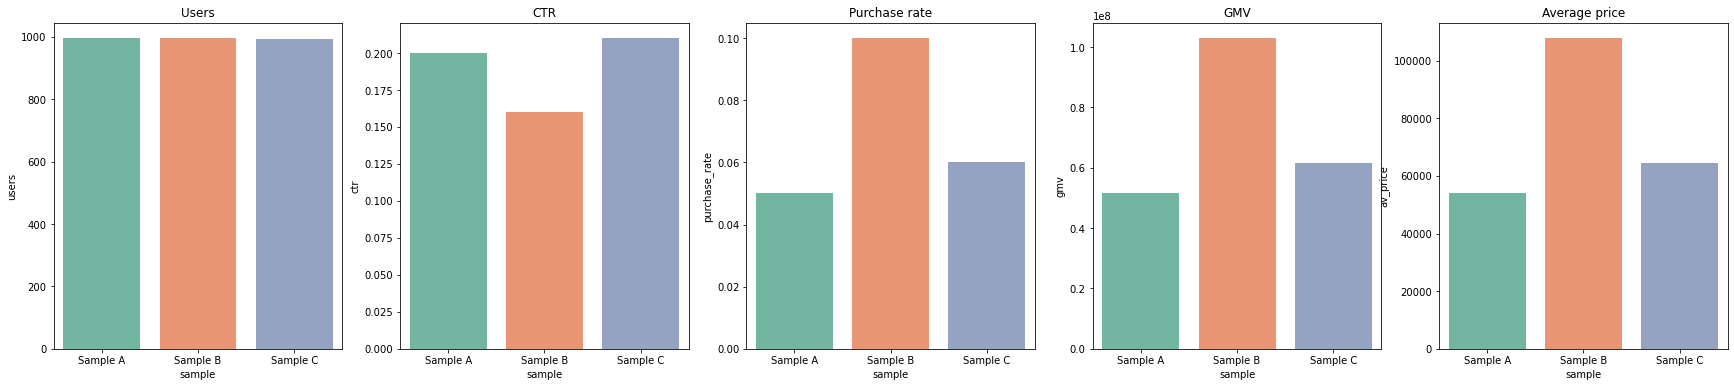

In [37]:
f, axs = plt.subplots(1,5, figsize=(30, 6))

sns.barplot(ax=axs[0],
            x="sample",
            y="users",
            data=metrics,
            palette="Set2").set(title="Users")

sns.barplot(ax=axs[1],
            x="sample",
            y="ctr",
            data=metrics,
            palette="Set2").set(title="CTR")

sns.barplot(ax=axs[2],
            x="sample",
            y="purchase_rate",
            data=metrics,
            palette="Set2").set(title="Purchase rate")

sns.barplot(ax=axs[3],
            x="sample",
            y="gmv",
            data=metrics,
            palette="Set2").set(title="GMV")

sns.barplot(ax=axs[4],
            x="sample",
            y="av_price",
            data=metrics,
            palette="Set2").set(title="Average price")

f.show()

Согласноусловиям данного задания, выборка А и выборка С должны быть идентичны с точки зрения метрик, так как являются тестовыми группами A/A. Они конечно сопоставимы, но gmv и средняя цена в выборке C примерно на 20% выше, что указывает на неравенство распределения по группам.

Образец B явно отличается от двух других с точки зрения показателей: ctr меньше примерно на 20%, но коэффициент покупок и gmv почти в 2 раза больше! В то же время количество пользователей совпадает с другими группами.

То есть, они быстрее покупают понравившийся им товар, и эти товары значительно дороже, чем в других группах.

Алгоритм B значительно повышает производительность торговой площадки.

## Statistical data

Заменим все nan нулём, а остальное единицами

In [38]:
def get_replace(data):
    data['browse'] = data['browse'].apply(lambda x: 1 if math.isnan(x)==False else 0)
    data['click'] = data['click'].apply(lambda x: 1 if math.isnan(x)==False else 0)
    data['purchase'] = data['purchase'].apply(lambda x: 1 if math.isnan(x)==False else 0)
    return (data)
def get_user_m(data):
    need_cols = ['user_id', 'browse', 'click', 'purchase', 'purchase_cost']
    data_users = data[need_cols].groupby('user_id').sum()
    data_users['ctr'] = data_users['click']/data_users['browse']
    data_users['purchase_rate'] = data_users['purchase']/data_users['browse']
    data_users['gmv'] = data_users['purchase_cost']
    
    return data_users
def distr(data):
    alpha = 0.01
    test_df['ctr_distr'] = test_df['ctr_test'].apply(lambda x: 'norm' if x>alpha else 'not')
    test_df['purchase_rate_distr'] = test_df['purchase_rate_test'].apply(lambda x: 'norm' if x>alpha else 'not')
    test_df['gmv_distr'] = test_df['gmv_test'].apply(lambda x: 'norm' if x>alpha else 'not')
    return test_df

In [39]:
#Sample A
sample_a_piv = get_replace(sample_a_piv)

#Sample B
sample_b_piv = get_replace(sample_b_piv)

#Sample C
sample_c_piv = get_replace(sample_c_piv)

In [40]:
sample_a_piv['purchase_cost'] = sample_a_piv['purchase']*sample_a_piv['item_price']
sample_b_piv['purchase_cost'] = sample_b_piv['purchase']*sample_b_piv['item_price']
sample_c_piv['purchase_cost'] = sample_c_piv['purchase']*sample_c_piv['item_price']

In [41]:
users_a = get_user_m(sample_a_piv)
users_b = get_user_m(sample_b_piv)
users_c = get_user_m(sample_c_piv)

In [42]:
users_a

,browse,click,purchase,purchase_cost,ctr,purchase_rate,gmv
user_id,,,,,,,
241,955,179,47,48104,0.187435,0.049215,48104
253,955,192,37,38676,0.201047,0.038743,38676
362,955,178,50,60230,0.186387,0.052356,60230
378,955,195,51,59325,0.204188,0.053403,59325
475,955,197,50,50680,0.206283,0.052356,50680
...,...,...,...,...,...,...,...
99401,955,208,39,37528,0.217801,0.040838,37528
99543,955,178,43,49150,0.186387,0.045026,49150
99555,955,196,61,63711,0.205236,0.063874,63711


In [43]:
users_b

,browse,click,purchase,purchase_cost,ctr,purchase_rate,gmv
user_id,,,,,,,
100038,955,167,100,103885,0.174869,0.104712,103885
100099,955,161,119,130575,0.168586,0.124607,130575
100164,955,140,98,100946,0.146597,0.102618,100946
100321,955,180,96,102379,0.188482,0.100524,102379
100397,955,153,81,92298,0.160209,0.084817,92298
...,...,...,...,...,...,...,...
199692,955,151,94,104024,0.158115,0.098429,104024
199772,955,143,95,100818,0.149738,0.099476,100818
199784,955,148,92,101050,0.154974,0.096335,101050


In [44]:
users_c

,browse,click,purchase,purchase_cost,ctr,purchase_rate,gmv
user_id,,,,,,,
200225,955,196,49,50795,0.205236,0.051309,50795
200278,955,203,58,56392,0.212565,0.060733,56392
200282,955,209,70,82814,0.218848,0.073298,82814
200325,955,185,44,49660,0.193717,0.046073,49660
200441,954,202,49,53309,0.211740,0.051363,53309
...,...,...,...,...,...,...,...
299616,955,209,54,55608,0.218848,0.056545,55608
299648,955,205,52,54384,0.214660,0.054450,54384
299650,955,190,54,58697,0.198953,0.056545,58697


In [45]:
users_a['sample'] = 'Sample A'
users_b['sample'] = 'Sample B'
users_c['sample'] = 'Sample C'

users = [users_a, users_b, users_c]
df_metrics = pd.concat(users)

<ipython-input-46-1f114edba440>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


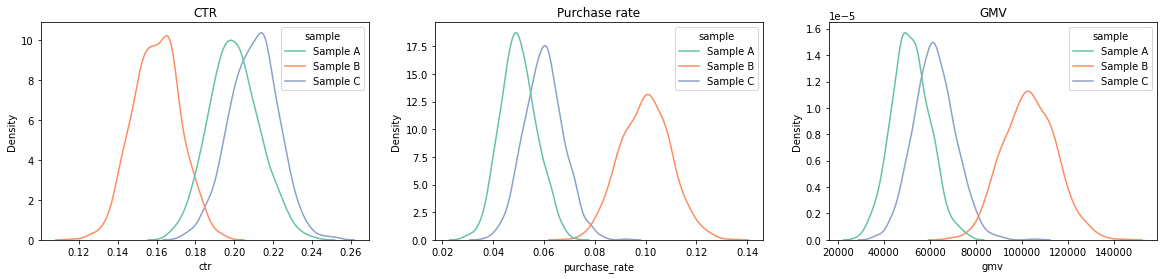

In [46]:
f, axs = plt.subplots(1,3, figsize=(20, 4))

sns.kdeplot(ax=axs[0],
            x="ctr",
            hue="sample",
            data=df_metrics,
            palette="Set2").set(title="CTR")

sns.kdeplot(ax=axs[1],
            x="purchase_rate",
            hue="sample",
            data=df_metrics,
            palette="Set2").set(title="Purchase rate")

sns.kdeplot(ax=axs[2],
            x="gmv",
            hue="sample",
            data=df_metrics,
            palette="Set2").set(title="GMV")

f.show()

Как и в более ранних исследованиях видно, что поведение потребителей в sample В существенно отличается от групп А и С. Максимальный CTR одинаков в обеих группах, но средний показатель в выборке В ниже.

A и C показывают больше сходства, как и следовало ожидать, но они имеют разные максимальные и средние значения

In [47]:
###Shapiro-Wilk test

#CTR
users_a_CTR = shapiro(users_a.ctr).pvalue
users_b_CTR = shapiro(users_b.ctr).pvalue
users_c_CTR = shapiro(users_c.ctr).pvalue

#purchase_rate
users_a_PR = shapiro(users_a.purchase_rate).pvalue
users_b_PR = shapiro(users_b.purchase_rate).pvalue
users_c_PR = shapiro(users_c.purchase_rate).pvalue

#GMV
users_a_GMV = shapiro(users_a.gmv).pvalue
users_b_GMV = shapiro(users_b.gmv).pvalue
users_c_GMV = shapiro(users_c.gmv).pvalue

#Making frame
test_df = {'sample': ['Sample A', 'Sample B', 'Sample C'],
              'ctr_test': [users_a_CTR, users_b_CTR, users_c_CTR],
              'purchase_rate_test': [users_a_PR, users_b_PR, users_c_PR],
              'gmv_test': [users_a_GMV, users_b_GMV, users_c_GMV]}

test_df = pd.DataFrame(test_df)

#Evaluate distribution (alpha = 0.01)
test_df = distr(test_df)

display(test_df)

,sample,ctr_test,purchase_rate_test,gmv_test,ctr_distr,purchase_rate_distr,gmv_distr
0,Sample A,0.024915,0.005959,0.069037,norm,not,norm
1,Sample B,0.331949,0.232916,0.778033,norm,norm,norm
2,Sample C,0.171084,0.022773,0.007006,norm,norm,not


При оценке распределения с помощью теста Шапиро-Уилка на альфа = 0,01, purchase_rate_distr в sample А и gmv в sample С распределены ненормально.

Попробуем нормализовать распределение, отобрав пользователей, совершивших не менее 30 покупок в обеих группах, а затем повторно оценить распределение, используя тот же метод.

In [48]:
users_a_30 = users_a[users_a['purchase']>=30]
users_b_30 = users_b[users_b['purchase']>=30]
users_c_30 = users_c[users_c['purchase']>=30]

#CTR
users_a_CTR = shapiro(users_a_30.ctr).pvalue
users_b_CTR = shapiro(users_b_30.ctr).pvalue
users_c_CTR = shapiro(users_c_30.ctr).pvalue

#purchase_rate
users_a_PR = shapiro(users_a_30.purchase_rate).pvalue
users_b_PR = shapiro(users_b_30.purchase_rate).pvalue
users_c_PR = shapiro(users_c_30.purchase_rate).pvalue

#GMV
users_a_GMV = shapiro(users_a_30.gmv).pvalue
users_b_GMV = shapiro(users_b_30.gmv).pvalue
users_c_GMV = shapiro(users_c_30.gmv).pvalue

#Making frame
test_df = {'sample': ['Sample A', 'Sample B', 'Sample C'],
              'ctr_test': [users_a_CTR, users_b_CTR, users_c_CTR],
              'purchase_rate_test': [users_a_PR, users_b_PR, users_c_PR],
              'gmv_test': [users_a_GMV, users_b_GMV, users_c_GMV]}

test_df = pd.DataFrame(test_df)

#Evaluate distribution (alpha = 0.01)
test_df = distr(test_df)

display(test_df)

,sample,ctr_test,purchase_rate_test,gmv_test,ctr_distr,purchase_rate_distr,gmv_distr
0,Sample A,0.028399,0.000757,0.013842,norm,not,norm
1,Sample B,0.331949,0.232916,0.778033,norm,norm,norm
2,Sample C,0.171084,0.022773,0.007006,norm,norm,not


Даже после попытки нормализовать распределение путем отбора пользователей, совершивших 30 или более покупок в Sample A и Sample C, распределения по показателям purchase_rate в A и gmv в C остались ненормальными, что говорит о том, что эти группы не идентичны друг другу и результаты, полученные по этим выборкам, не могут восприниматься как A / A тестирование.

In [49]:
#Z-testing, alpha = 0.05

#A&C Samples

#CTR
successes = np.array([users_a_30.click.sum(), users_c_30.click.sum()])
samples = np.array([users_a_30.browse.sum(), users_c_30.browse.sum()])

stat, ac_ctr = proportions_ztest(count=successes, nobs=samples)

#GMV
successes = np.array([users_a_30.purchase.sum(), users_c_30.purchase.sum()])
samples = np.array([users_a_30.browse.sum(), users_c_30.browse.sum()])

stat, ac_purchase = proportions_ztest(count=successes, nobs=samples)

print(ac_ctr, ac_purchase)

2.7522360757339227e-65 7.036894459652539e-198


In [50]:
#A&B Samples

#CTR
successes = np.array([users_a_30.click.sum(), users_b_30.click.sum()])
samples = np.array([users_a_30.browse.sum(), users_b_30.browse.sum()])

stat, ab_ctr = proportions_ztest(count=successes, nobs=samples)

#GMV
successes = np.array([users_a_30.purchase.sum(), users_b_30.purchase.sum()])
samples = np.array([users_a_30.browse.sum(), users_b_30.browse.sum()])

stat, ab_purchase = proportions_ztest(count=successes, nobs=samples)

print(ab_ctr, ab_purchase)

0.0 0.0


Как мы видим  поведение пользователей в sample В существенно отличается от остальных.

In [51]:
#T-test, alpha = 0.05
#A&C Samples
stat, ac_ctr = ttest_ind(users_a_30['ctr'], users_c_30['ctr'])
stat, ac_purch = ttest_ind(users_a_30['purchase_rate'], users_c_30['purchase_rate'])
stat, ac_gmv = ttest_ind(users_a_30['gmv'], users_c_30['gmv'])

print(ac_ctr, ac_purch, ac_gmv)

1.7920723829814243e-63 8.103045015908895e-163 3.1274433527864994e-131


In [52]:
#A&B Samples
stat, ab_ctr = ttest_ind(users_a_30['ctr'], users_b_30['ctr'])
stat, ab_purch = ttest_ind(users_a_30['purchase_rate'], users_b_30['purchase_rate'])
stat, ab_gmv = ttest_ind(users_a_30['gmv'], users_b_30['gmv'])

print(ab_ctr, ab_purch, ab_gmv)

0.0 0.0 0.0


Во время тестирования sample А и sample С показали большее сходство, чем при математическом анализе и при анализе графиков. Таким образом, мы можем сказать, что тест A/A можно считать успешным.
В то же время sample В показывают существенное оличие (как мы видели ранее), то есть алгоритм, который был протестирован в sample В, существенно меняет поведение потребителей и приводит к увеличение прибыли на одного пользователя и оборота в целом. 